### Zabezpieczanie portfela (hedging) - Prophet Timeseries¶

Budowa modelu predykcyjnego dla wybranego portfela zestawów w oparciu o dane rynkowe (rentowności obligacji skarbowych USA, główne indeksy giełdowe USA). - Analiza zwrotu i odchylenia portfela skorelowanych replikującego ceny wybranego zestawu w wybranym okresie (2023-2024

In [ ]:
# Importuję biblioteki 

from time import time
import datetime as dt
# from pathlib import Path
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from ipywidgets import IntProgress
# from IPython.display import display

# from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot

Najpierw pobieram dane z tabelki z cenami.

Porzucam kolumnę `Name`, zmieniam `Date` do formatu czasowego i wyliczam `IQR` oraz `Midhinge`.

Pozbywam się danych z ostatniego miesiąca (czerwca 2024).

In [2]:
price_df = pd.read_csv("./data/Brickonomy_Prices_22_06_2024.csv")
price_df = price_df.drop(columns=["Name"])
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df['IQR'] = price_df['Q3'] - price_df['Q1']
price_df['Midhinge'] = 0.5*(price_df['Q3'] + price_df['Q1'])
price_df = price_df[price_df['Date'] < price_df['Date'].max()]

Przerobiłam tabelę na przestawną, gdzie indeksem jest czas (`Date`), kolumnami są zestawy (`Set_no`) zaś wartościami jest cena (`Midhinge`). Mam zgrabną reprezentację zmian cen zestawów na przestrzeni czasu.

Wtedy każda kolumna jest szeregiem czasowym cen konkretnego zestawu.

Jak widać, niektóre zestawy mają `NaN`-y.

In [3]:
prices_by_set_df = pd.pivot_table(price_df, index='Date', columns='Set_no', values='Midhinge')
prices_by_set_df

Set_no,100 Stores Minifigure,1000-1,10000-1,10002-1,10003-1,10004-1,10006-1,10007-1,10008-1,10009-1,...,San Diego Comic-Con Rocket Raccoon's Warbird,Science Tower,Skyline Express,Steampunk Mini Chess,Tatooine Mini Build,The LEGO Story,Vintage Roadster,White Boba Fett Minifig and Star Wars Character Encyclopedia,Wild West Saloon,Zane
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,NaN,160.535,119.020,219.915,47.035,43.665,29.070,6.845,23.440,6.825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-02-01,NaN,160.590,119.925,221.710,47.450,43.945,29.280,6.850,23.575,6.830,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-03-01,NaN,151.970,114.235,211.280,45.235,41.810,27.880,6.485,22.420,6.465,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-01,NaN,161.420,122.200,226.125,48.445,44.675,29.810,6.895,23.945,6.870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-01,NaN,162.230,123.650,228.925,49.070,45.160,30.155,6.930,24.190,6.905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,43.4575,226.475,412.980,646.995,139.835,111.790,78.585,10.530,57.180,9.850,...,521.825,376.465,484.290,235.415,381.565,209.265,218.135,76.570,433.045,11.99
2024-02-01,43.7675,240.220,477.485,686.750,134.535,111.905,78.675,8.200,48.690,10.455,...,395.470,352.160,457.860,198.215,325.990,206.200,195.505,60.220,485.160,13.80
2024-03-01,41.2200,236.555,473.145,552.505,140.855,105.980,76.315,8.955,50.875,10.500,...,432.475,390.035,471.075,201.685,403.765,192.090,225.570,67.895,497.930,11.00


Upewniam się, że wszystkie czasy (miesiące) między pierwszym (min) czasem a ostatnim (max) występują w tabeli.

W tym celu liczę czasy, które powinny być w zakresie (`all_dates_in_range`), a z indeksu pobieram czasy, które są faktycznie (`all_dates_in_index`).

Liczę różnice między oboma zbiorami i wychodzi na to, że jest pusty - czyli w indeksie są wszystkie czasy od min do maxa.

In [4]:
all_dates_in_range = pd.date_range(start=price_df['Date'].min(), end=price_df['Date'].max(), freq='MS').values

In [5]:
all_dates_in_index = prices_by_set_df.index.sort_values().values

In [6]:
np.setdiff1d(all_dates_in_range, all_dates_in_index)

array([], dtype='datetime64[ns]')

Dodatkowo wyliczam tabele zwrotów - `1m`, `3m`, oraz `12m`/`1y`.

W tym celu używam metody `pct_change` z ustawionym odpowiednio argumentem `periods` - dla `1m` jest to `1`, dla `3m` jest to `3`, a dla `1y` jest to `12`.

Pozbywam się pierwszego rzędu, ponieważ jest on cały `NaN`-owy - wynika to z tego, że pierwszy rząd nie ma poprzedniego, aby wyliczyć zmianę procentową.

Ponadto, zamieniam nieskończoności `Inf` na `NaN`-y - będzie mi łatwiej pracować z tymi tabelami, jak `Inf`-y będą `NaN`-ami.

In [7]:
monthly_returns_by_set_df = prices_by_set_df.pct_change(periods=1).iloc[1:].replace([np.inf, -np.inf], np.nan)
monthly_returns_by_set_df

Set_no,100 Stores Minifigure,1000-1,10000-1,10002-1,10003-1,10004-1,10006-1,10007-1,10008-1,10009-1,...,San Diego Comic-Con Rocket Raccoon's Warbird,Science Tower,Skyline Express,Steampunk Mini Chess,Tatooine Mini Build,The LEGO Story,Vintage Roadster,White Boba Fett Minifig and Star Wars Character Encyclopedia,Wild West Saloon,Zane
Date,,,,,,,,,,,,,,,,,,,,,
2009-02-01,NaN,0.000343,0.007604,0.008162,0.008823,0.006412,0.007224,0.000730,0.005759,0.000733,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-03-01,NaN,-0.053677,-0.047446,-0.047043,-0.046681,-0.048583,-0.047814,-0.053285,-0.048993,-0.053441,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-01,NaN,0.062183,0.069725,0.070262,0.070963,0.068524,0.069225,0.063223,0.068020,0.062645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-01,NaN,0.005018,0.011866,0.012383,0.012901,0.010856,0.011573,0.005076,0.010232,0.005095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-01,NaN,-0.038926,-0.032228,-0.031779,-0.031282,-0.033437,-0.032499,-0.038961,-0.033898,-0.039102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,-0.159673,-0.152493,-0.233569,-0.018790,0.101670,-0.107821,0.202617,0.037438,0.152590,-0.160988,...,0.107544,0.013201,0.017501,-0.156219,-0.194450,-0.143252,0.017516,0.020729,-0.142443,-0.156228
2024-02-01,0.007133,0.060691,0.156194,0.061446,-0.037902,0.001029,0.001145,-0.221273,-0.148478,0.061421,...,-0.242141,-0.064561,-0.054575,-0.158019,-0.145650,-0.014647,-0.103743,-0.213530,0.120345,0.150959
2024-03-01,-0.058205,-0.015257,-0.009089,-0.195479,0.046977,-0.052947,-0.029997,0.092073,0.044876,0.004304,...,0.093572,0.107551,0.028863,0.017506,0.238581,-0.068429,0.153781,0.127449,0.026321,-0.202899


In [8]:
quarterly_returns_by_set_df = prices_by_set_df.pct_change(periods=3).iloc[3:].replace([np.inf, -np.inf], np.nan)
quarterly_returns_by_set_df

Set_no,100 Stores Minifigure,1000-1,10000-1,10002-1,10003-1,10004-1,10006-1,10007-1,10008-1,10009-1,...,San Diego Comic-Con Rocket Raccoon's Warbird,Science Tower,Skyline Express,Steampunk Mini Chess,Tatooine Mini Build,The LEGO Story,Vintage Roadster,White Boba Fett Minifig and Star Wars Character Encyclopedia,Wild West Saloon,Zane
Date,,,,,,,,,,,,,,,,,,,,,
2009-04-01,NaN,0.005513,0.026718,0.028238,0.029978,0.023131,0.025456,0.007305,0.021544,0.006593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-01,NaN,0.010212,0.031061,0.032543,0.034141,0.027648,0.029884,0.011679,0.026087,0.010981,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-01,NaN,0.025959,0.047534,0.049082,0.050846,0.044009,0.046449,0.026985,0.042373,0.026295,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,NaN,0.010377,0.031137,0.032637,0.034266,0.027756,0.030023,0.010877,0.026101,0.010917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-08-01,NaN,0.005609,0.026243,0.027695,0.029244,0.022808,0.025037,0.005772,0.021290,0.006517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,-0.279730,0.008438,-0.080100,0.061805,0.065937,0.012820,0.054549,0.049327,0.043716,-0.059666,...,0.323623,-0.007317,-0.064047,0.148366,-0.265487,-0.025269,0.087033,0.104667,-0.012789,-0.110864
2024-02-01,-0.137799,-0.051563,0.128086,0.327836,-0.092451,-0.056251,0.030924,-0.104803,0.087559,-0.224694,...,-0.197756,-0.010939,-0.019624,-0.212745,-0.336650,-0.203061,0.016720,-0.170238,-0.037629,0.164557
2024-03-01,-0.202939,-0.114772,-0.121911,-0.162090,0.109706,-0.154190,0.167878,-0.117734,0.025499,-0.105622,...,-0.082096,0.049723,-0.010263,-0.277115,-0.147582,-0.213568,0.052197,-0.094914,-0.013951,-0.225897


In [9]:
yearly_returns_by_set_df = prices_by_set_df.pct_change(periods=12).iloc[12:].replace([np.inf, -np.inf], np.nan)
yearly_returns_by_set_df

Set_no,100 Stores Minifigure,1000-1,10000-1,10002-1,10003-1,10004-1,10006-1,10007-1,10008-1,10009-1,...,San Diego Comic-Con Rocket Raccoon's Warbird,Science Tower,Skyline Express,Steampunk Mini Chess,Tatooine Mini Build,The LEGO Story,Vintage Roadster,White Boba Fett Minifig and Star Wars Character Encyclopedia,Wild West Saloon,Zane
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,0.032174,0.118341,0.124616,0.131498,0.103973,0.113519,0.036523,0.097483,0.035165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-01,NaN,0.032038,0.117157,0.123292,0.129926,0.102970,0.112534,0.036496,0.096713,0.035139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-03-01,NaN,0.031980,0.116077,0.122113,0.128883,0.102248,0.111549,0.035466,0.095897,0.035576,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-01,NaN,0.031904,0.114975,0.120907,0.127361,0.101287,0.110533,0.034808,0.095009,0.034934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-01,NaN,0.031838,0.113910,0.119690,0.125943,0.100421,0.109435,0.034632,0.094461,0.035482,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,-0.018298,0.022184,-0.081859,0.163179,0.056475,0.389731,0.029745,0.034889,0.041246,-0.026680,...,-0.027815,0.060136,0.580426,1.088772,-0.201363,-0.090666,0.457440,-0.121198,-0.091692,0.481161
2024-02-01,-0.010009,0.022126,0.238275,0.114185,0.056876,0.255526,0.086296,-0.333333,-0.049951,0.013572,...,-0.198025,0.158154,0.348392,0.587117,-0.308640,-0.066483,0.324829,-0.162390,0.224935,0.538462
2024-03-01,-0.211855,0.022145,0.236076,-0.280794,0.163274,0.042136,0.006595,-0.124205,-0.032243,0.076371,...,-0.009902,0.079816,0.402990,0.302622,-0.215800,-0.069850,0.185744,-0.144414,0.158219,-0.048854


In [10]:
yearly_stds_by_set_df = prices_by_set_df.rolling(window=12).std().iloc[12:].replace([np.inf, -np.inf], np.nan)
yearly_stds_by_set_df

Set_no,100 Stores Minifigure,1000-1,10000-1,10002-1,10003-1,10004-1,10006-1,10007-1,10008-1,10009-1,...,San Diego Comic-Con Rocket Raccoon's Warbird,Science Tower,Skyline Express,Steampunk Mini Chess,Tatooine Mini Build,The LEGO Story,Vintage Roadster,White Boba Fett Minifig and Star Wars Character Encyclopedia,Wild West Saloon,Zane
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,9.292126,9.522454,17.977755,3.935242,3.321626,2.286092,0.402612,1.741529,0.401291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-01,NaN,9.254265,9.438587,17.817883,3.899804,3.293826,2.266490,0.400820,1.727338,0.399520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-03-01,NaN,8.767378,8.376894,15.784917,3.448286,2.938350,2.014424,0.377908,1.545384,0.376783,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-01,NaN,8.727124,8.281305,15.600866,3.407377,2.906414,1.991586,0.376099,1.529212,0.374944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-01,NaN,8.707498,8.230414,15.502696,3.385114,2.890145,1.979499,0.375155,1.521011,0.374090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,5.708455,13.037877,51.031460,79.896339,10.425759,8.836303,5.316928,1.165567,4.311230,1.067635,...,44.117273,28.171882,66.670003,49.149835,72.819835,22.713412,31.924618,6.397755,51.852931,1.521086
2024-02-01,5.735902,13.110478,48.545042,80.000010,10.379915,6.429957,5.574973,1.102854,4.387414,1.065706,...,50.229120,21.357511,56.971078,41.634827,83.148538,23.404142,27.302709,7.591650,44.685050,1.296128
2024-03-01,5.849436,13.037431,43.925988,75.937909,10.064315,6.011724,5.597001,1.128254,4.369605,1.036319,...,50.524816,22.045799,41.593219,37.378493,81.878377,24.763100,27.477040,7.500067,40.935243,1.335241


Chcę pracować z zestawami/szeregami, które od wybranego momentu (np. styczeń 2014) nie będą mieć żadnych `NaN`-ów.

W tym celu korzystam z funkcji `get_valid_sets_since_date`, która dokładnie to robi:
- Najpierw filtruje tabelę, aby zostały tylko te rzędy, które są po wybranej dacie;
- Następnie wyrzuca te kolumny, które mają `NaN`-y (`dropna(axis=1)`);
- Tak przekształconą tabelę zwraca.

In [12]:
def get_valid_sets_since_date(df: pd.DataFrame, cutoff_date: dt.date):
    """
    Ta metoda bierze tabelkę, gdzie kolumnami są szeregi czasowe (zestawy), a indeksem są timestampy.
    Zwraca przefiltrowaną tabelkę, gdzie kolumnami są te szeregi czasowe (zestawy), które po `cutoff_date` nie mają żadnych NaN-ów.
    """
    return df[df.index >= pd.to_datetime(cutoff_date)].dropna(axis=1)

Za pomocą tej metody, mogę teraz pobrać zestawy, które np. od `2010-01-01` mają zupełne dane i dla nich policzyć korelację w przypadku cen lub zwrotów:

In [75]:
valid_prices_by_set_since_2010_df = get_valid_sets_since_date(prices_by_set_df, dt.date(2010, 1, 1))

In [76]:
valid_monthly_returns_by_set_since_2010_df = get_valid_sets_since_date(monthly_returns_by_set_df, dt.date(2010, 1, 1))

Szybki rzut okiem sugeruje, że zestaw `1000-1` oraz `10000-1` mają różne korelacje cen i zwrotów - chyba należy dodatkowo wystandardyzować ceny, aby móc miarodajne wyliczyć korelację.

A może jest w tym coś?

### Wizualizacja trendu i sezonowości za pomocą Propheta

In [27]:
def display_seasonality_and_trend(df, name = ""):
    train_df = pd.DataFrame({"Midhinge": df.mean(axis=1)}).reset_index().rename(columns={'Date': 'ds', 'Midhinge': 'y'})
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False) # mcmc_samples=300
    m.fit(train_df)
    future = m.make_future_dataframe(periods=24, freq='MS')
    forecast = m.predict(future)
    fig_forecast = m.plot(forecast)
    fig_changepoints = add_changepoints_to_plot(fig_forecast.gca(), m, forecast)
    if name:
        plt.savefig(f"{name}_forecast.png", bbox_inches='tight')
    else:
        plt.show()
    fig_components = m.plot_components(forecast)
    if name:
        plt.savefig(f"{name}_components.png", bbox_inches='tight')
    else:
        plt.show()

In [ ]:
for year in range(2010, 2020):
    valid_prices_by_set_since_year_df = get_valid_sets_since_date(prices_by_set_df, dt.date(year, 1, 1))
    print(f"{[year]}: Forecast, Trend, Seasonality of Prices")
    display_seasonality_and_trend(valid_prices_by_set_since_year_df, f"prices_{year}")

In [ ]:
for year in range(2010, 2020):
    valid_sets_by_year_df = get_valid_sets_since_date(monthly_returns_by_set_df, dt.date(year, 1, 1))
    print(f"{[year]}: Forecast, Trend, Seasonality of Monthly returns")
    display_seasonality_and_trend(valid_sets_by_year_df, f"monthly_rets_{year}")

In [ ]:
for year in range(2010, 2020):
    valid_prices_by_set_since_year_df = get_valid_sets_since_date(yearly_returns_by_set_df, dt.date(year, 1, 1))
    print(f"{[year]}: Forecast, Trend, Seasonality of Yearly returns")
    display_seasonality_and_trend(valid_prices_by_set_since_year_df, f"yearly_rets_{year}")

### Zastąpienie inwestycji w drogi zestaw portfelem tańszych zestawów

Spójrzmy na zestawy dostępne od 2010 roku z punktu widzenia średniego zwrotu z okresu `1y` oraz na odchylenie standardowe owych zwrotów:

In [33]:
valid_yearly_returns_by_set_since_2010_df = get_valid_sets_since_date(yearly_returns_by_set_df, dt.date(2010, 1, 1))
valid_yearly_stds_by_set_since_2010_df = get_valid_sets_since_date(yearly_stds_by_set_df, dt.date(2010, 1, 1))

In [34]:
valid_yearly_returns_by_set_since_2010_df.shape == valid_yearly_stds_by_set_since_2010_df.shape

False

In [35]:
common_sets = np.intersect1d(valid_yearly_stds_by_set_since_2010_df.columns, valid_yearly_returns_by_set_since_2010_df.columns)
common_sets.shape

(2757,)

In [36]:
valid_yearly_returns_by_set_since_2010_df = valid_yearly_returns_by_set_since_2010_df[common_sets]
valid_yearly_stds_by_set_since_2010_df = valid_yearly_stds_by_set_since_2010_df[common_sets]

In [37]:
valid_yearly_returns_by_set_since_2010_df.shape == valid_yearly_stds_by_set_since_2010_df.shape

True

In [3]:
mean_rets_df = valid_yearly_returns_by_set_since_2010_df.mean()
std_rets_df = valid_yearly_stds_by_set_since_2010_df.std()
mean_price_df = prices_by_set_df.mean()
means_stds_df = mean_rets_df.to_frame("Yearly returns (mean)").join(std_rets_df.to_frame("Price (yearly std)")).join(mean_price_df.to_frame("Price (mean)")).sort_values(by=["Yearly returns (mean)", "Price (mean)", "Price (yearly std)"], ascending=[False, False, False])
means_stds_df

In [1]:
valid_prices_correlation_df = valid_prices_by_set_since_2010_df.corr()
valid_prices_correlation_df

NameError: name 'valid_prices_by_set_since_2010_df' is not defined

In [78]:
valid_prices_correlation_df['3347-1'].sort_values(ascending=False)

Set_no
3347-1    1.000000
7103-1    0.975487
7113-1    0.971155
7111-1    0.970950
8530-1    0.968730
            ...   
5252-1   -0.520609
1506-1   -0.525087
4027-1   -0.562042
4603-1   -0.626869
3424-1   -0.628272
Name: 3347-1, Length: 2924, dtype: float64

In [85]:
means_stds_df[means_stds_df.index.isin(valid_prices_correlation_df['3347-1'].sort_values(ascending=False)[1:10].index)]

,Midhinge (mean),Price (std),Price (mean)
Set_no,,,
8530-1,0.251677,0.342915,27.621405
6024-1,0.186832,0.285764,76.169730
4476-1,0.176640,0.199147,64.230378
7133-1,0.167931,0.262463,156.335243
7103-1,0.153650,0.221712,56.654541
7113-1,0.149179,0.235387,45.600216
7111-1,0.132390,0.195981,22.123838
7115-1,0.130061,0.188683,44.275405
7201-1,0.127098,0.223235,27.199811


Będę budować model oparty o dane rynkowe dla danego setu - obligacje skarbowe i amerykańskie, 1 miesięczne, 4 miesięczne itp.
Dane pobrałam wcześniej z odpowiednich stron: 
- Yahoo!Finance: SPX, DJI, IXIC, RUT.
- Federal Reserve Bank: GS1M, GS3M, GS6M, GS1, GS2, GS3, GS5, GS7, GS10, GS20, GS30.

In [86]:
# Buduję model oparty o dane rynkowe dla danego setu

ust_maturities = ["1M", "3M", "6M", "1Y", "2Y", "3Y", "5Y", "7Y", "10Y", "20Y", "30Y"]
ust_dfs = [pd.read_csv(f"./data/mkt/UST_GS{ust_maturity}_2009_2024_monthly.csv", parse_dates=['DATE'], date_parser=lambda x: dt.datetime.strptime(x, "%Y-%m-%d")).rename(columns={"DATE": "Date"}).set_index("Date").sort_index() for ust_maturity in ust_maturities]
ust_df = pd.concat(ust_dfs, axis=1)

In [87]:
# Ładuję dane indeksów - będę posługiwać się cenami z otwarcia oraz wolumenem

idxs = ["^SPX", "^DJI", "^IXIC", "^RUT"] # "^VIX" okazuje sie, że jest pusto-zerowy, wiec pomijam go
idx_open_dfs = []
idx_volume_dfs = []
for idx in idxs:
    idx_df = pd.read_csv(f"./data/mkt/{idx}_2009_2024_monthly.csv", index_col=[0], date_parser=lambda x: dt.datetime.strptime(x, "%Y-%m-%d")).sort_index()
    idx_open_df = idx_df[["Open"]].rename(columns={"Open": f'{idx} open'})
    idx_open_dfs.append(idx_open_df)
    idx_volume_df = idx_df[["Volume"]].rename(columns={"Volume": f'{idx} volume'})
    idx_volume_dfs.append(idx_volume_df)
idx_open_df = pd.concat(idx_open_dfs, axis=1)
idx_volume_df = pd.concat(idx_volume_dfs, axis=1)

In [88]:
all_regressors_df = pd.concat([ust_df, idx_open_df, idx_volume_df], axis=1)
all_regressors_df

,GS1M,GS3M,GS6M,GS1,GS2,GS3,GS5,GS7,GS10,GS20,GS30,^SPX open,^DJI open,^IXIC open,^RUT open,^SPX volume,^DJI volume,^IXIC volume,^RUT volume
Date,,,,,,,,,,,,,,,,,,,
2009-01-01,0.05,0.13,0.30,0.44,0.81,1.13,1.60,1.98,2.52,3.46,3.13,902.99,8772.25,1578.869995,499.510010,112090640000,6261980000,39995600000,112090640000
2009-02-01,0.22,0.30,0.46,0.62,0.98,1.37,1.87,2.30,2.87,3.83,3.59,823.09,8000.62,1460.849976,441.209991,124492210000,7134360000,42380620000,124492210000
2009-03-01,0.10,0.22,0.43,0.64,0.93,1.31,1.82,2.42,2.82,3.78,3.64,729.57,7056.48,1356.130005,389.010010,161843640000,10561060000,49480930000,161843640000
2009-04-01,0.10,0.16,0.35,0.55,0.93,1.32,1.86,2.47,2.93,3.84,3.76,793.59,7606.13,1504.869995,419.390015,138855320000,7795900000,48683640000,138855320000
2009-05-01,0.14,0.18,0.30,0.50,0.93,1.39,2.13,2.81,3.29,4.22,4.23,872.74,8167.41,1719.290039,488.089996,131614940000,6734390000,47352030000,131614940000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,5.54,5.45,5.21,4.79,4.32,4.11,3.98,4.03,4.06,4.39,4.26,4745.20,37566.22,14873.700195,2012.750000,81737880000,7141910000,111351260000,81737880000
2024-02-01,5.49,5.44,5.28,4.92,4.54,4.33,4.19,4.21,4.21,4.49,4.38,4861.11,38175.34,15254.019531,1959.579956,82066930000,6258860000,106763830000,82066930000
2024-03-01,5.51,5.47,5.36,4.99,4.59,4.38,4.20,4.21,4.21,4.46,4.36,5098.51,38989.51,16109.830078,2058.479980,86299510000,7300670000,106387420000,86299510000


In [91]:
# Będzę pracować na jednym wybranym zestawie - wybrałam "8530-1" bo jest najtańszy, ma stosunkowo małe wahania i dobry zwrot

regressand_df = valid_prices_by_set_since_2010_df[["8530-1"]]

In [164]:
# Łączę wszystko w jedną tabelę - załadowane są ceny (nie zwroty!) zestawu "8530-1"

full_df = pd.concat([regressand_df, all_regressors_df], axis=1)
full_df

,8530-1,GS1M,GS3M,GS6M,GS1,GS2,GS3,GS5,GS7,GS10,GS20,GS30,^SPX open,^DJI open,^IXIC open,^RUT open,^SPX volume,^DJI volume,^IXIC volume,^RUT volume
Date,,,,,,,,,,,,,,,,,,,,
2009-01-01,NaN,0.05,0.13,0.30,0.44,0.81,1.13,1.60,1.98,2.52,3.46,3.13,902.99,8772.25,1578.869995,499.510010,112090640000,6261980000,39995600000,112090640000
2009-02-01,NaN,0.22,0.30,0.46,0.62,0.98,1.37,1.87,2.30,2.87,3.83,3.59,823.09,8000.62,1460.849976,441.209991,124492210000,7134360000,42380620000,124492210000
2009-03-01,NaN,0.10,0.22,0.43,0.64,0.93,1.31,1.82,2.42,2.82,3.78,3.64,729.57,7056.48,1356.130005,389.010010,161843640000,10561060000,49480930000,161843640000
2009-04-01,NaN,0.10,0.16,0.35,0.55,0.93,1.32,1.86,2.47,2.93,3.84,3.76,793.59,7606.13,1504.869995,419.390015,138855320000,7795900000,48683640000,138855320000
2009-05-01,NaN,0.14,0.18,0.30,0.50,0.93,1.39,2.13,2.81,3.29,4.22,4.23,872.74,8167.41,1719.290039,488.089996,131614940000,6734390000,47352030000,131614940000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,113.960,5.54,5.45,5.21,4.79,4.32,4.11,3.98,4.03,4.06,4.39,4.26,4745.20,37566.22,14873.700195,2012.750000,81737880000,7141910000,111351260000,81737880000
2024-02-01,119.245,5.49,5.44,5.28,4.92,4.54,4.33,4.19,4.21,4.21,4.49,4.38,4861.11,38175.34,15254.019531,1959.579956,82066930000,6258860000,106763830000,82066930000
2024-03-01,109.025,5.51,5.47,5.36,4.99,4.59,4.38,4.20,4.21,4.21,4.46,4.36,5098.51,38989.51,16109.830078,2058.479980,86299510000,7300670000,106387420000,86299510000


In [165]:
# Zmieniam nazwy kolumny: `Date` na `ds` oraz `60088-1` na `y` (żeby Prophet zaakceptował format)
full_df = full_df.reset_index().rename(columns={'Date': 'ds', '8530-1': 'y'})
full_df

,ds,y,GS1M,GS3M,GS6M,GS1,GS2,GS3,GS5,GS7,...,GS20,GS30,^SPX open,^DJI open,^IXIC open,^RUT open,^SPX volume,^DJI volume,^IXIC volume,^RUT volume
0,2009-01-01,NaN,0.05,0.13,0.30,0.44,0.81,1.13,1.60,1.98,...,3.46,3.13,902.99,8772.25,1578.869995,499.510010,112090640000,6261980000,39995600000,112090640000
1,2009-02-01,NaN,0.22,0.30,0.46,0.62,0.98,1.37,1.87,2.30,...,3.83,3.59,823.09,8000.62,1460.849976,441.209991,124492210000,7134360000,42380620000,124492210000
2,2009-03-01,NaN,0.10,0.22,0.43,0.64,0.93,1.31,1.82,2.42,...,3.78,3.64,729.57,7056.48,1356.130005,389.010010,161843640000,10561060000,49480930000,161843640000
3,2009-04-01,NaN,0.10,0.16,0.35,0.55,0.93,1.32,1.86,2.47,...,3.84,3.76,793.59,7606.13,1504.869995,419.390015,138855320000,7795900000,48683640000,138855320000
4,2009-05-01,NaN,0.14,0.18,0.30,0.50,0.93,1.39,2.13,2.81,...,4.22,4.23,872.74,8167.41,1719.290039,488.089996,131614940000,6734390000,47352030000,131614940000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2024-01-01,113.960,5.54,5.45,5.21,4.79,4.32,4.11,3.98,4.03,...,4.39,4.26,4745.20,37566.22,14873.700195,2012.750000,81737880000,7141910000,111351260000,81737880000
181,2024-02-01,119.245,5.49,5.44,5.28,4.92,4.54,4.33,4.19,4.21,...,4.49,4.38,4861.11,38175.34,15254.019531,1959.579956,82066930000,6258860000,106763830000,82066930000
182,2024-03-01,109.025,5.51,5.47,5.36,4.99,4.59,4.38,4.20,4.21,...,4.46,4.36,5098.51,38989.51,16109.830078,2058.479980,86299510000,7300670000,106387420000,86299510000
183,2024-04-01,108.140,5.48,5.44,5.38,5.14,4.87,4.71,4.56,4.56,...,4.77,4.66,5257.97,39807.93,16397.050781,2125.909912,81747170000,7743400000,107535290000,81747170000


In [166]:
#pozbywam się NaNów. Zabiera mi 1 rok danych, ale to raczej nie problem.
full_df = full_df.dropna()

In [167]:
# Wybieram daty do zbiorów treningowych i testowych. Wybrałam od lata 2015 do 2023 do trenowania. 
# Będę testowała dane na datach od 2023 do 2024.

train_date_start = pd.to_datetime(dt.date(2015, 1, 1))
train_date_end = pd.to_datetime(dt.date(2023, 1, 1))
test_date_start = train_date_end
test_date_end = pd.to_datetime(dt.date(2024, 1, 1))

In [168]:
#Przefiltruwuję dane, aby zakres dat się zgadzał
full_df = full_df[(train_date_start <= full_df.ds) & (full_df.ds < test_date_end)]

In [169]:
#Przygotowuję zbiory danych do treningu i testowania.
train_df = full_df[(train_date_start <= full_df.ds) & (full_df.ds < train_date_end)]
test_df = full_df[(test_date_start <= full_df.ds) & (full_df.ds < test_date_end)]

In [170]:
# Tworzę model w oparciu o bibliotekę Prophet 
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
for regressor in all_regressors_df.columns:
    m.add_regressor(regressor)
m.fit(train_df)

23:00:35 - cmdstanpy - INFO - Chain [1] start processing
23:00:36 - cmdstanpy - INFO - Chain [1] done processing


In [171]:
#Buduję zbiór danych do predykcji

future_df = full_df[list(all_regressors_df.columns) + ["ds"]]
future_df

,GS1M,GS3M,GS6M,GS1,GS2,GS3,GS5,GS7,GS10,GS20,GS30,^SPX open,^DJI open,^IXIC open,^RUT open,^SPX volume,^DJI volume,^IXIC volume,^RUT volume,ds
72,0.02,0.03,0.08,0.20,0.55,0.90,1.37,1.67,1.88,2.20,2.46,2058.90,17823.07,4760.240234,1209.979980,77330040000,2173260000,38719030000,77300040000,2015-01-01
73,0.02,0.02,0.07,0.22,0.62,0.99,1.47,1.79,1.98,2.34,2.57,1996.67,17169.99,4650.600098,1168.579956,68775560000,1751250000,35773090000,68775560000,2015-02-01
74,0.02,0.03,0.11,0.25,0.64,1.02,1.52,1.84,2.04,2.41,2.63,2105.23,18134.05,4973.430176,1233.390015,76675850000,2470480000,41204240000,76675850000,2015-03-01
75,0.02,0.02,0.09,0.23,0.54,0.87,1.35,1.69,1.94,2.33,2.59,2067.63,17778.52,4894.359863,1250.989990,72060940000,2174880000,37409760000,69440940000,2015-04-01
76,0.01,0.02,0.08,0.24,0.61,0.98,1.54,1.93,2.20,2.69,2.96,2087.38,17859.27,4966.319824,1223.050049,65187730000,1832450000,35994540000,65187730000,2015-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,5.54,5.56,5.54,5.37,4.90,4.59,4.31,4.26,4.17,4.46,4.28,4578.83,35585.99,14274.929688,1996.890015,86840820000,7048360000,110754840000,86840820000,2023-08-01
176,5.53,5.56,5.51,5.44,5.02,4.74,4.49,4.46,4.38,4.65,4.47,4530.60,34876.24,14129.959961,1908.170044,73482980000,6186180000,94727650000,73482980000,2023-09-01
177,5.57,5.60,5.57,5.42,5.07,4.89,4.77,4.82,4.80,5.13,4.95,4284.52,33455.50,13217.980469,1780.859985,83519460000,6689000000,97818540000,79952900000,2023-10-01
178,5.53,5.52,5.44,5.28,4.88,4.64,4.49,4.53,4.50,4.84,4.66,4201.27,33081.87,12887.059570,1661.410034,80970570000,6275680000,95884580000,80970570000,2023-11-01


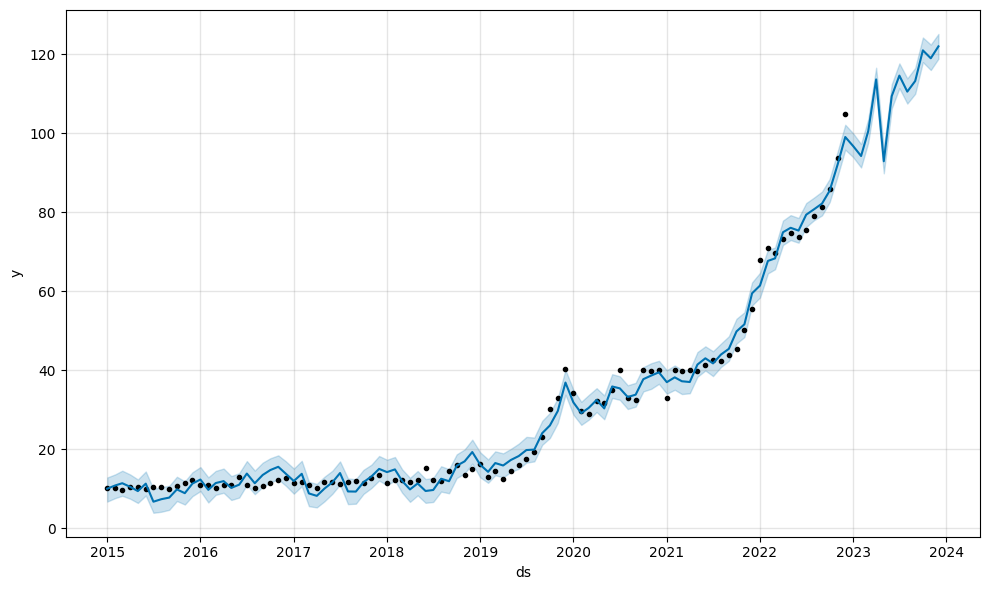

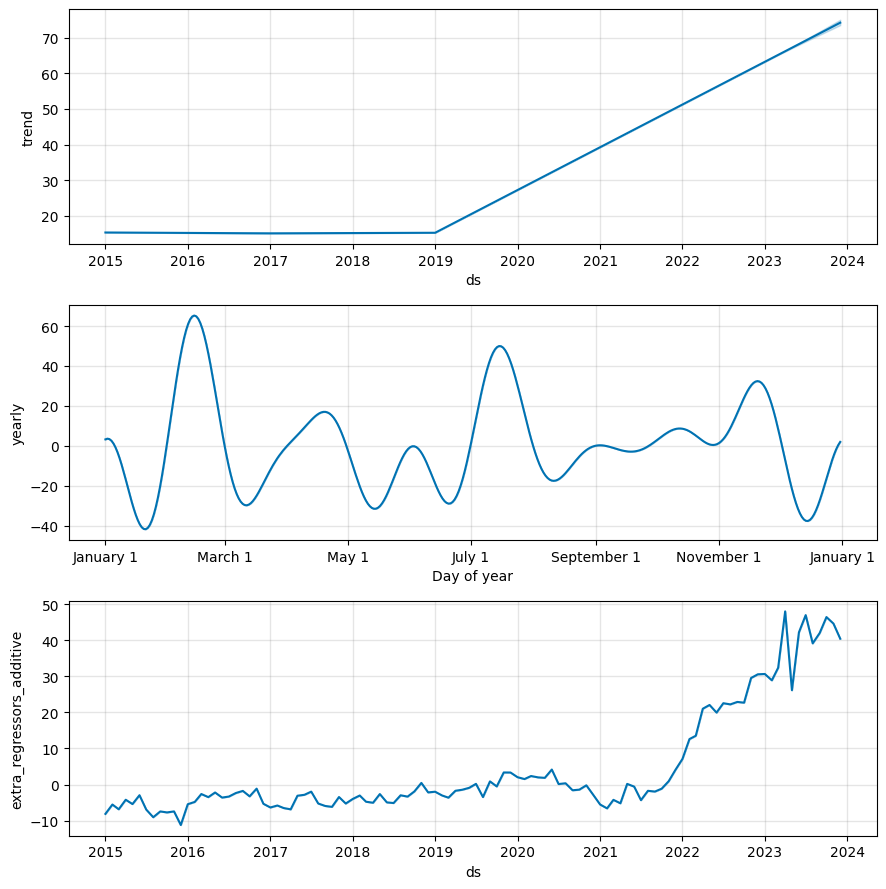

In [172]:
forecast = m.predict(future_df)
fig_fcst = m.plot(forecast)
fig_cmpnts = m.plot_components(forecast)

In [173]:
# Liczę błąd absolutny, błąd względny i błąd względny w procencie i pokazuję predyckję yhat wyliczoną przez model

validation_df = forecast[["ds", "yhat"]].merge(full_df[["ds", "y"]], on="ds")
validation_df["abs_err"] = (validation_df["yhat"] - validation_df["y"]).abs()
validation_df["rel_err"] = validation_df["abs_err"]/validation_df["y"]
validation_df["rel_err (%)"] = validation_df["rel_err"]*100
validation_df

,ds,yhat,y,abs_err,rel_err,rel_err (%)
0,2015-01-01,9.989137,10.165,0.175863,0.017301,1.730088
1,2015-02-01,10.796504,10.195,0.601504,0.059000,5.899991
2,2015-03-01,11.371480,9.670,1.701480,0.175954,17.595447
3,2015-04-01,10.456647,10.295,0.161647,0.015702,1.570155
4,2015-05-01,9.378481,10.375,0.996519,0.096050,9.605000
...,...,...,...,...,...,...
103,2023-08-01,110.519554,114.800,4.280446,0.037286,3.728612
104,2023-09-01,113.211746,112.800,0.411746,0.003650,0.365023
105,2023-10-01,120.975430,118.210,2.765430,0.023394,2.339422
106,2023-11-01,118.963740,113.960,5.003740,0.043908,4.390787


In [180]:
# Tyle wynosi błąd średniokwadratowy na całym okresie
math.sqrt(validation_df['abs_err'].pow(2).mean())

3.8714605620265754

In [181]:
# Tyle wynosi błąd średniokwadratowy na okresie testowym. Nie jest najmniejszy, ale nie ma tragedii! :)
math.sqrt(validation_df[test_date_start <= validation_df.ds]['abs_err'].pow(2).mean())

9.421853645572423

In [185]:
#Tutaj  zestawienie cen 'drogiego' zestawu i zestawu 'zastępczego' dla okresu imnwestycyjnego (2023-2024)
two_sets_df = valid_prices_by_set_since_2010_df[test_date_start <= valid_prices_by_set_since_2010_df.index][["3347-1", "8530-1"]]
two_sets_df

Set_no,3347-1,8530-1
Date,,
2023-01-01,528.730,92.840
2023-02-01,554.095,97.290
2023-03-01,492.980,99.495
2023-04-01,410.000,98.195
2023-05-01,419.295,100.420
2023-06-01,413.810,105.240
2023-07-01,492.980,91.165
2023-08-01,461.345,114.800
2023-09-01,478.670,112.800


In [189]:
two_sets_df[two_sets_df.index == pd.to_datetime(dt.date(2023, 1, 1))]

Set_no,3347-1,8530-1
Date,,
2023-01-01,528.73,92.84


In [206]:
#Sprawdzam ile zestawów muszę kupić, żeby wyjść "na swoje"
ratio = (two_sets_df[two_sets_df.index == pd.to_datetime(dt.date(2023, 1, 1))]["3347-1"]/two_sets_df[two_sets_df.index == pd.to_datetime(dt.date(2023, 1, 1))]["8530-1"])[0]
ratio

5.695066781559673

 Zakładam, że będziemy mieli portfel o stałym składzie - czyli kupujemy ilość zestawu 'zastępczego' w takiej ilości, by 
 odpowiadał cenie zakupu zestawu 'drogiego' na początku okresu inwestycyjnego. 
 Czyli około 5-6 sztuk

In [207]:
portfolio_vs_set_df = two_sets_df.copy().rename(columns={"8530-1": "Portfolio"})
portfolio_vs_set_df["Portfolio"] = portfolio_vs_set_df["Portfolio"]*ratio
portfolio_vs_set_df

Set_no,3347-1,Portfolio
Date,,
2023-01-01,528.730,528.730000
2023-02-01,554.095,554.073047
2023-03-01,492.980,566.630669
2023-04-01,410.000,559.227083
2023-05-01,419.295,571.898606
2023-06-01,413.810,599.348828
2023-07-01,492.980,519.190763
2023-08-01,461.345,653.793667
2023-09-01,478.670,642.403533


### Porównanie zwrotów i zmienności

In [3]:
# Liczę kwartalny zwrot z inwestycji
portfolio_vs_set_df.pct_change(periods=3).iloc[3:].replace([np.inf, -np.inf], np.nan)

In [4]:
# Liczę kwartalną zmienność.

Tutaj widać, że nie zawsze 1-elementowy statyczny portfel dobrze zabezpiecza drogi zestaw,
# bo ogólna wariancja jest jednak wysoka. Trzeba zbudować portfel w oparciu o większą liczbę skorelowanych zestawów. 
portfolio_vs_set_df.rolling(window=3).std().iloc[3:].replace([np.inf, -np.inf], np.nan)

In [5]:
# Liczę roczne zwroty
portfolio_vs_set_df.pct_change(periods=12).iloc[12:].replace([np.inf, -np.inf], np.nan)

In [6]:
# Liczę roczną zmienność
portfolio_vs_set_df.rolling(window=12).std().iloc[12:].replace([np.inf, -np.inf], np.nan)